[Epoch 1/10] Loss: 0.3297 | Train Acc: 82.29%
           >> Val Loss: 0.2512 | Val Acc: 85.67%

Saved Best Model 
[Epoch 2/10] Loss: 0.2394 | Train Acc: 86.81%
           >> Val Loss: 0.3136 | Val Acc: 82.14%

No improvement, patience: 1/3
[Epoch 3/10] Loss: 0.2229 | Train Acc: 87.05%
           >> Val Loss: 0.2577 | Val Acc: 85.96%

Saved Best Model 
[Epoch 4/10] Loss: 0.1884 | Train Acc: 88.82%
           >> Val Loss: 0.2809 | Val Acc: 84.15%

No improvement, patience: 1/3
[Epoch 5/10] Loss: 0.1730 | Train Acc: 90.18%
           >> Val Loss: 0.2925 | Val Acc: 84.34%

No improvement, patience: 2/3
[Epoch 6/10] Loss: 0.1794 | Train Acc: 90.20%
           >> Val Loss: 0.2121 | Val Acc: 88.25%

Saved Best Model 
[Epoch 7/10] Loss: 0.1773 | Train Acc: 90.42%
           >> Val Loss: 0.2863 | Val Acc: 84.24%

No improvement, patience: 1/3
[Epoch 8/10] Loss: 0.1708 | Train Acc: 90.78%
           >> Val Loss: 0.2253 | Val Acc: 87.68%

No improvement, patience: 2/3
[Epoch 9/10] Loss: 0.1630 | 

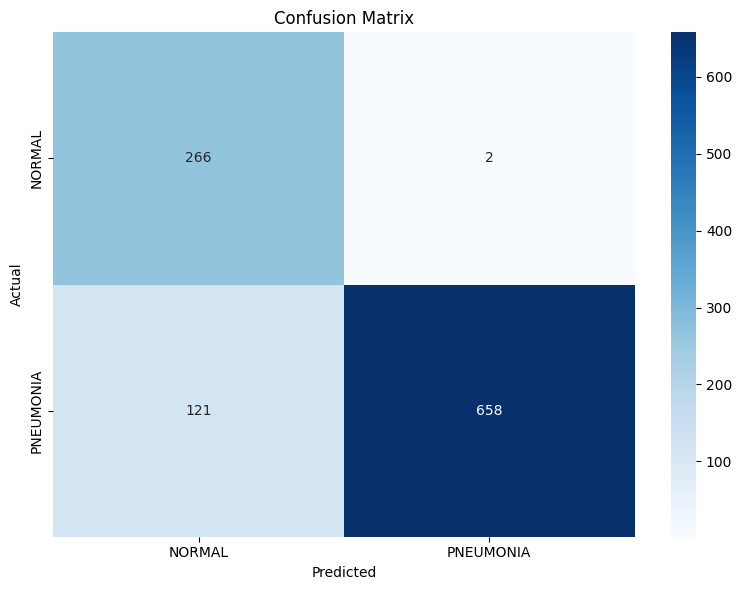

Predicted Disease: PNEUMONIA


In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_transform = transforms.Compose([
    transforms.Resize((140, 140)),
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


full_dataset = datasets.ImageFolder(root="dataset", transform=train_transform)
label_names = full_dataset.classes
num_classes = len(label_names)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transform
val_dataset = torch.utils.data.Subset(
    datasets.ImageFolder(root="dataset", transform=val_transform),
    val_dataset.indices
)

train_targets = [label for _, label in train_dataset]
class_counts = Counter(train_targets)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_targets]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

weights_tensor = torch.tensor([class_weights[i] for i in range(num_classes)], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

best_val_acc = 0.0
patience = 3
patience_counter = 0
save_path = "best_model.pth"

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = 100 * correct / total
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"           >> Val Loss: {val_loss / len(val_loader):.4f} | Val Acc: {val_acc:.2f}%\n")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print("Saved Best Model ")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement, patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered ")
            break

    scheduler.step()

model.load_state_dict(torch.load(save_path))

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

def predict_disease(image_path, model_path="best_model.pth"):
    image = Image.open(image_path).convert("RGB")
    image = val_transform(image).unsqueeze(0).to(device)

    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_label = label_names[predicted.item()]
        print(f"Predicted Disease: {predicted_label}")
          
predict_disease("BACTERIA-103798-0002.jpeg")